In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [55]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [56]:
len(words)

32033

In [57]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [96]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [97]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [60]:
print(X[0])
print(C[X[0]])

tensor([0, 0, 0])
tensor([[-0.5363,  0.2783],
        [-0.5363,  0.2783],
        [-0.5363,  0.2783]])


In [61]:
C = torch.randn((27,2))

In [62]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [63]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [70]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [71]:
h

tensor([[ 0.9727, -0.9147, -0.4840,  ..., -0.1998,  0.9939,  0.9929],
        [-0.9451, -1.0000,  0.2214,  ...,  0.2535,  0.9255,  0.9738],
        [ 0.9869, -0.9993,  0.9336,  ...,  0.9999,  0.9907,  0.9987],
        ...,
        [ 0.2641, -0.9998, -0.8206,  ...,  0.8927,  0.3396,  0.2818],
        [-0.9411, -0.9999,  0.1940,  ...,  0.9857, -0.9802, -0.7225],
        [ 0.6664, -0.9944,  0.3246,  ...,  0.9967, -0.7698,  0.6881]])

In [72]:
h.shape

torch.Size([32, 100])

In [73]:
W2 = torch.randn(100,27)
b2 = torch.randn(27)

In [74]:
logits = h @ W2 + b2

In [75]:
logits.shape

torch.Size([32, 27])

In [76]:
counts = logits.exp()

In [77]:
prob = counts / counts.sum(1, keepdims = True)

In [78]:
prob[0].sum()

tensor(1.0000)

In [80]:
loss = -prob[torch.arange(32),Y].log().mean()

In [81]:
loss

tensor(16.2116)

In [98]:
# --- Now made respectable

In [104]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [138]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn((100), generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn((27), generator = g)
parameters = [C, W1, b1, W2, b2]

In [139]:
sum(p.nelement() for p in parameters) # number of parameters


3481

In [140]:
for p in parameters:
    p.requires_grad = True

In [145]:
for i in range(100000):
    # minibatch
    ix = torch.randint(0,X.shape[0],(32,))
    # forward pass
    emb = C[X[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update 
    lr = 0.1
    for p in parameters:
        p.data += -lr*p.grad
    # track stats 
    #lri.append(lre[i])
    #lossi.append(loss.item())

In [146]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.2639, grad_fn=<NllLossBackward0>)

In [147]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [148]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [149]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [151]:
for p in parameters:
    p.requires_grad = True

In [152]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [153]:
lri = []
lossi = []
stepi = []

In [154]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [155]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1328, grad_fn=<NllLossBackward0>)

In [156]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1718, grad_fn=<NllLossBackward0>)

In [157]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1745, grad_fn=<NllLossBackward0>)

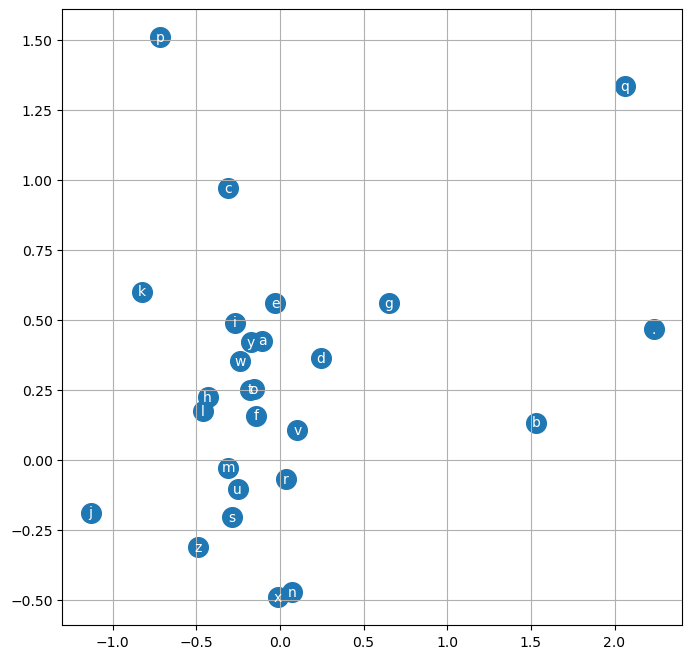

In [158]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [160]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndyn.
alanethaniendraige.
zeredielin.
shy.
jen.
edelisson.
arleity.
malaia.
nyshirerging.
jestin.
josellionniella.
ubrence.
ryyah.
faeli.
kayjahsin.
daihan.
salynn.
